<a href="https://colab.research.google.com/github/luisArthurRodriguesDaSilva/estudo-data-science-eleicoes/blob/master/apura%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
import pandas as pd
import numpy as np
import requests
import pprint
from matplotlib import pyplot as plt
import seaborn as sns
import cmath

In [3]:
BRAZIL_UFs = ["AC","AL","AM","AP","BA","CE","DF","ES","GO","MA","MT","MS","MG","PA","PB","PR","PE","PI","RJ","RN","RO","RS","RR","SC","SE","SP","TO"]
brasil_ufs = ['ac','al','am','ap','ba','ce','df','es','go','ma','mt','ms','mg','pa','pb','pr','pe','pi','rj','rn','ro','rs','rr','sc','se','sp','to']

In [4]:
def getDeputadoEstadualUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0007-e000546-r.json'

def getPresidentUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/544/dados-simplificados/{uf}/{uf}-c0001-e000544-r.json'

def getGovernadorUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0003-e000546-r.json'

def getDeputadoFederalUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0006-e000546-r.json'

def getSenadorUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0005-e000546-r.json'

gets= [getPresidentUrl, getSenadorUrl, getDeputadoFederalUrl, getDeputadoEstadualUrl, getGovernadorUrl]
categoryKeys= ['Presidente', 'Senador', 'DeputadoFederal', 'DeputadoEstadual', 'Governador']

In [5]:
def trabalhoDoJuan(url,uf): #taked on 
  re=requests.get(url).json()
  candidatos = re['cand'][:10]

  df=pd.DataFrame(candidatos)
  df=df[['nm','n','dvt','vap','pvap']]
  df.rename(columns={'nm':'Nome do Candidato',
                  'n':'Numero do Candidato',
                  'dvt':'Validade',
                  'vap':'Votos',
                  'pvap':'(%) Votos'}, inplace=True)

  df['Horario Atualização']=re['hg']
  df['(%) Votos']=df['(%) Votos'].str.replace(',','.')
  df['(%) Votos']=df['(%) Votos'].astype(float)
  df['Votos']=df['Votos'].astype(int)
  df['Nome do Candidato']=df['Nome do Candidato'].str.replace('D&apos;',"D'")
  df=df.sort_values(by='Votos', ascending=False)

  fig, axs = plt.subplots(ncols=1, figsize=(13,6))

  ax1 = sns.barplot(
      x="Nome do Candidato",
      y='(%) Votos',
      data=df[:10],
      palette="ch:.25",
      ax=axs)

  ax1.set(xlabel="Candidatos(as)",
          ylabel="(%) Votos",
          title=f"Apuração de resultados Eleições 2022 {uf} - Presidente - (5 mais Votados)",
          ylim=(0,70))


  # Adicionando rotulo com valores no gráfico ax1:
  for p in ax1.patches:
              ax1.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', fontsize=13, color='black', xytext=(2, 5),
                  textcoords='offset points')

  plt.show()

  print (f'Sessões Totais em {uf}: {re["s"]}')
  print (f'Sessões Apuradas em {uf}: {re["st"]}')
  pct=int(re['st'])/int(re['s'])*100
  print (f'Percentual de sessões apuradas em {uf}: {round(pct,4)}%')

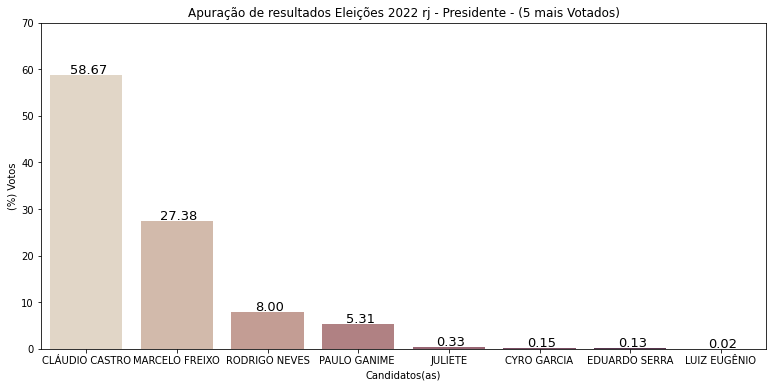

Sessões Totais em rj: 34068
Sessões Apuradas em rj: 34068
Percentual de sessões apuradas em rj: 100.0%


In [6]:
trabalhoDoJuan(getGovernadorUrl('rj'),'rj')

In [7]:
def takeData(url):
  re=requests.get(url).json()
  candidatos = re['cand']

  df=pd.DataFrame(candidatos)
  df=df[['nm','n','dvt','vap','pvap']]
  df.rename(columns={'nm':'Nome do Candidato',
                  'n':'Numero do Candidato',
                  'dvt':'Validade',
                  'vap':'Votos',
                  'pvap':'(%) Votos'}, inplace=True)
  
  df['(%) Votos']=df['(%) Votos'].str.replace(',','.')
  df['(%) Votos']=df['(%) Votos'].astype(float)
  df['Votos']=df['Votos'].astype(int)
  df['Nome do Candidato']=df['Nome do Candidato'].str.replace('D&apos;',"D'")
  df=df.sort_values(by='Votos', ascending=False)
  return(df)

In [8]:
def getAllDataByUf(uf):
  info = {}
  for index, category in enumerate(categoryKeys):
    try:
      info[category] = takeData(gets[index](uf))
    except:
      if uf == 'df':
        info[category] = 'df não tem prefeito'
      else:
        info[category] = 'this is brasil'
  return info

In [9]:
electionsData = {}
electionsData['br'] = getAllDataByUf('br')
for i, uf in  enumerate(brasil_ufs):
  electionsData[uf] = getAllDataByUf(uf)

In [18]:
arrayVersionElectionsData = list(map(lambda uf:electionsData[uf],brasil_ufs) )

In [109]:
def getDiffBetweenJairNine(uf):
  usedData = electionsData[uf]['Presidente'][:2].values
  #print(usedData)
  bolsonaroScore = list(filter(lambda x: x[0]== 'JAIR BOLSONARO',usedData))[0][4]
  nineScore = list(filter(lambda x: x[0]== 'LULA',usedData))[0][4]
  result = float(format(abs(bolsonaroScore - nineScore),'.2f'))
  if bolsonaroScore > nineScore:
    return [result,'tab:green']
  else:
    return [result, 'tab:red']

In [ ]:
ordened_ufs = sorted(brasil_ufs,key=lambda uf: getDiffBetweenJairNine(uf)[0])
#ordened_ufs.sort(key=lambda uf: getDiffBetweenJairNine(uf)[0])
print(ordened_ufs)
print(brasil_ufs)

[2.26, 4.69, 6.4, 6.61, 6.78, 6.82, 10.41, 11.83, 11.95, 12.65, 13.66, 14.8, 19.27, 20.45, 25.45, 31.96, 32.67, 33.24, 34.59, 34.66, 35.36, 35.38, 40.53, 42.82, 45.42, 46.52, 54.35]


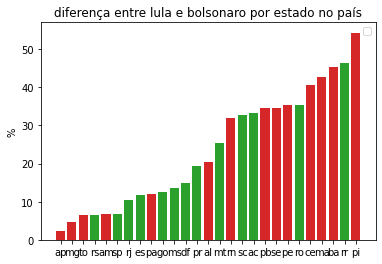

In [126]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

counts = (list(map(lambda uf : getDiffBetweenJairNine(uf)[0],brasil_ufs)))
bar_colors = list(map(lambda uf : getDiffBetweenJairNine(uf)[1],brasil_ufs))

ax.bar(brasil_ufs, counts, color = bar_colors) #label=bar_labels, color=bar_orscol)
ax.set_ylabel('%')
ax.set_title('diferença entre lula e bolsonaro por estado no país')
ax.legend()

plt.show()

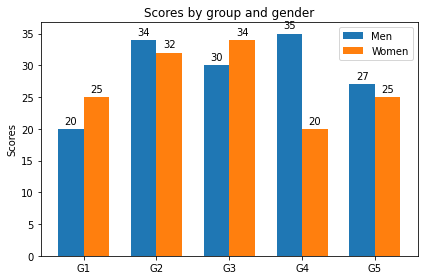

In [12]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()